TESS

* [ETE-6 TESS Simulated Data Products](http://archive.stsci.edu/tess/ete-6.html)

## TIC 315625354

Other possible EBs
* 329071596
* 329173835

In [1]:
base='https://archive.stsci.edu/missions/tess/ete-6/tid/00/'
name='000/003/156/tess2019128220341-0000000315625354-0016-s_lc.fits'

sample=base+name

In [2]:
from astropy.io import fits

hdr =fits.getheader(sample)
data=fits.getdata(sample)

In [3]:
hdr['OBJECT']

'TIC 315625354'

data._coldefs.names

## get lightcurve

In [4]:
import pandas as pd
from astropy.table import Table

tab = Table.read(sample, format='fits')
df = tab.to_pandas()

In [5]:
#df = df.dropna()
df.head()

,TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
0,1612.845907,0.005212,101,29061.906250,18.974405,1348.894165,3.716753,32755.066406,22.612148,0,NaN,NaN,NaN,NaN,2046.830837,0.000488,1394.050933,0.000401,-0.018330,-0.076125
1,1612.847295,0.005212,102,29224.681641,19.021301,1350.362915,3.719880,32934.097656,22.668036,0,NaN,NaN,NaN,NaN,2046.840414,0.000491,1394.051588,0.000399,-0.001761,-0.076494
2,1612.848684,0.005212,103,29121.171875,18.991068,1348.318848,3.715148,32814.855469,22.632006,0,NaN,NaN,NaN,NaN,2046.834712,0.000490,1394.051632,0.000401,-0.010969,-0.076975
3,1612.850073,0.005212,104,29137.251953,18.994368,1346.442139,3.715522,32838.238281,22.635939,0,NaN,NaN,NaN,NaN,2046.836560,0.000490,1394.050980,0.000401,-0.006714,-0.076730
4,1612.851462,0.005212,105,29125.068359,18.991844,1350.273193,3.719561,32819.308594,22.632931,0,NaN,NaN,NaN,NaN,2046.834777,0.000490,1394.051297,0.000401,-0.009434,-0.076612


In [6]:
df.shape

(20610, 20)

## convenience function

In [7]:
def get_data(data):
    t = data['TIME']
    f = data['SAP_FLUX']
    e = data['SAP_FLUX_ERR']
    b = data['SAP_BKG']

    x1 = data['POS_CORR1']
    x2 = data['POS_CORR2']
    return t,f,e,b,x1,x2

Text(0.5,0,'time')

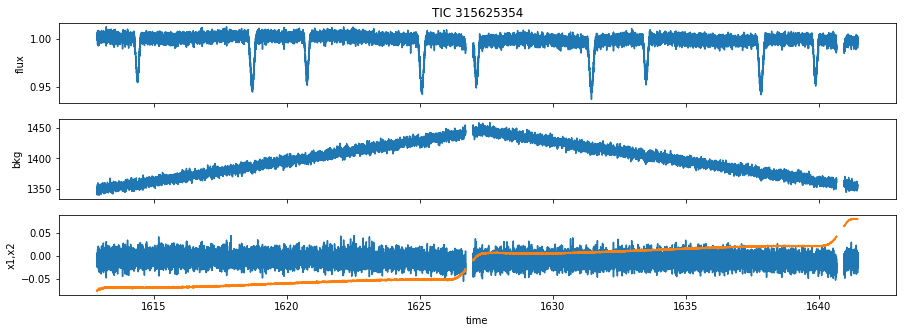

In [8]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

t,f,e,b,x1,x2 = get_data(data)

fig, ax = pl.subplots(3,1,figsize=(15,5), sharex=True)
n=0
ax[n].plot(t,f/np.nanmedian(f))
ax[n].set_title(hdr['OBJECT'])
ax[n].set_ylabel('flux')
n=1
ax[n].plot(t,b)
ax[n].set_ylabel('bkg')
n=2
ax[n].plot(t,x1)
ax[n].plot(t,x2)
ax[n].set_ylabel('x1,x2')

ax[-1].set_xlabel('time')

Remove NaNs. Otherwise, `LombScargleFast` will invoke `assertion error: df > 0`.

In [9]:
df2=df[['TIME','SAP_FLUX','SAP_FLUX_ERR']].dropna()

t,f,e= df2['TIME'], df2['SAP_FLUX'], df2['SAP_FLUX_ERR'] 

f = f/np.nanmedian(f)

t, f, e = np.array(t), np.array(f), np.array(e)

Thinning will enable faster periodogram calculation.

In [22]:
import gatspy
from gatspy.periodic import LombScargleFast # see also LombScargleAstroML

thin = 10
model = LombScargleFast().fit(t[::thin], f[::thin], e[::thin])
periods, power = model.periodogram_auto(nyquist_factor=100)

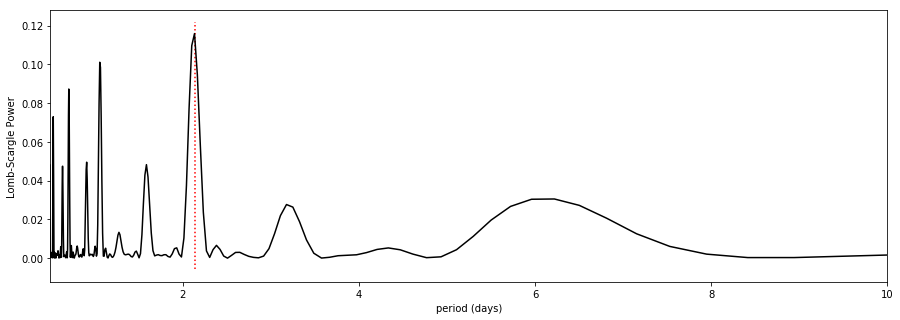

In [29]:
idx1 = periods > 1
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 10),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

In [12]:
peak

2.135159673503634

Text(0.5,0,'phase')

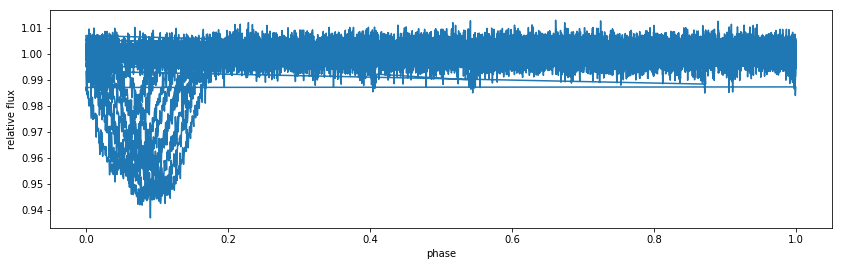

In [66]:
phase = (t/peak) % 1

fig, ax = pl.subplots(1,1,figsize=(14,4), sharex=True)

pl.plot(phase,f)
pl.ylabel('relative flux')
pl.xlabel('phase')

The period is a multiple of the two periods. There is a broad bump in periodogram around 6.1 so I'll use period*3.

In [14]:
def get_mask(time, t0, period, dur=0.2):
    '''
    Mask all of the transits/eclipses of a given planet/EB. 
    
    :param float t0: The time of first transit (same units as light curve)
    :param float period: The period of the planet in days
    :param foat dur: The transit duration in days. Default 0.2
    
    '''
    mask = []
    t0 += np.ceil((time[0] - dur - t0) / period) * period
    for t in np.arange(t0, time[-1] + dur, period):
        mask.extend(np.where(np.abs(time - t) < dur / 2.)[0])
        
    return mask

def apply_mask(time, mask):
    return np.delete(time, mask, axis=0)

## period1

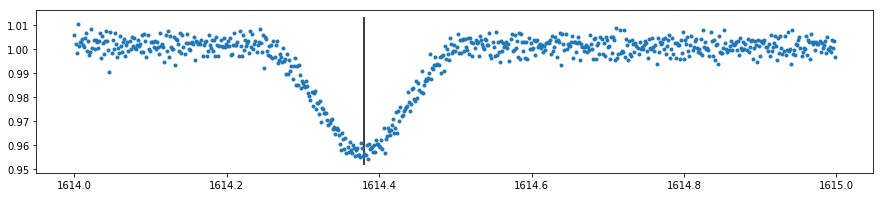

In [15]:
idx = (1614 < t) & (t < 1615)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t01 = np.median(tsub[idx])

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t01, *ax.get_ylim())

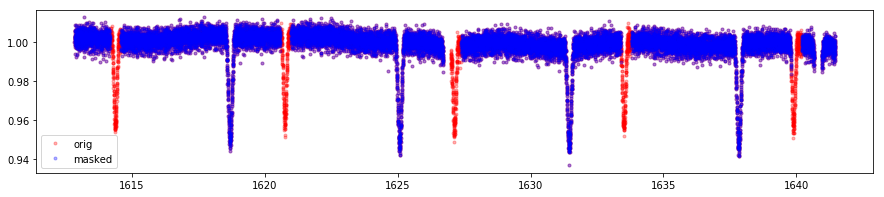

In [27]:
p1 = peak*3

mask=get_mask(t, t01, p1, dur=0.4)

tm=apply_mask(t,mask)
fm=apply_mask(f,mask)
em=apply_mask(e,mask)

fig, ax = pl.subplots(1,1,figsize=(15,3))

ax.plot(t,f,'r.',alpha=0.3,label='orig')
ax.plot(tm,fm,'b.',alpha=0.3,label='masked')
ax.legend()

(0.6, 0.8)

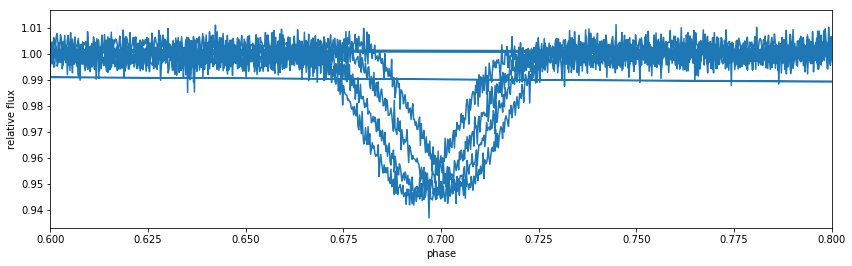

In [74]:
phase = (tm/p1) % 1

fig, ax = pl.subplots(1,1,figsize=(14,4), sharex=True)

pl.plot(phase,fm)
pl.ylabel('relative flux')
pl.xlabel('phase')
pl.xlim(0.6,0.8)

In [30]:
import gatspy
from gatspy.periodic import LombScargleFast # see also LombScargleAstroML

thin = 10
model = LombScargleFast().fit(tm[::thin], fm[::thin], em[::thin])
periods, power = model.periodogram_auto(nyquist_factor=100)

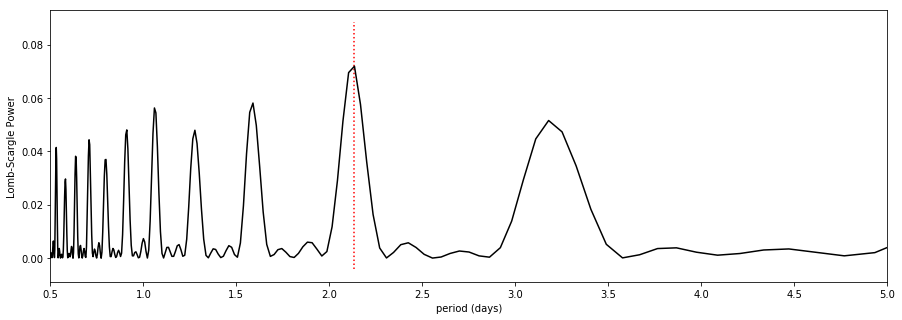

In [31]:
idx1 = periods > 1
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 5),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

## period2

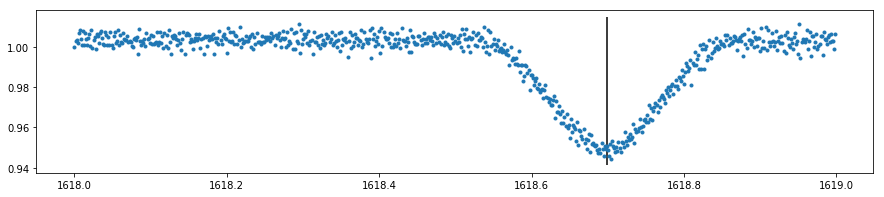

In [32]:
idx = (1618 < t) & (t < 1619)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t02 = np.median(tsub[idx])

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t02, *ax.get_ylim())

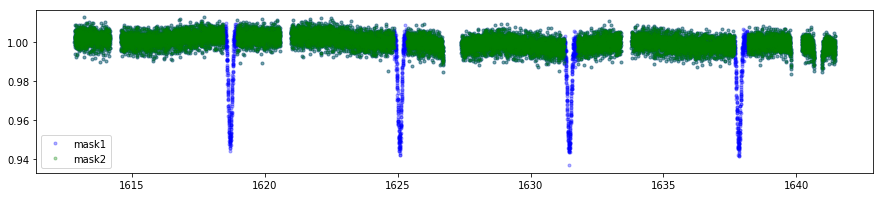

In [71]:
p2 = peak*3
mask2=get_mask(tm, t02, p2, dur=0.5)

tm2=apply_mask(tm,mask2)
fm2=apply_mask(fm,mask2)

fig, ax = pl.subplots(1,1,figsize=(15,3))

ax.plot(tm,fm,'b.',alpha=0.3,label='mask1')
ax.plot(tm2,fm2,'g.',alpha=0.3,label='mask2')
ax.legend()

Having similar period but different phase implies eclipse? Is this an eclipsing binary? and V-shape!

(0.6, 0.8)

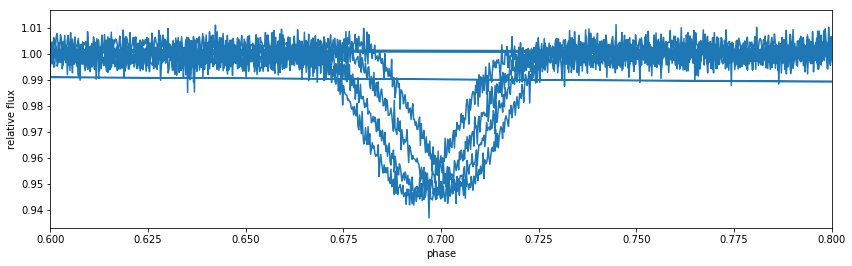

In [73]:
phase = (tm/p2) % 1

fig, ax = pl.subplots(1,1,figsize=(14,4), sharex=True)

pl.plot(phase,fm)
pl.ylabel('relative flux')
pl.xlabel('phase')
pl.xlim(0.6,0.8)

In [72]:
#import simfit
#tf, ff = simfit.util.fold(t, f, peak, t0)

def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns


def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.2):
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

In [ ]:
from pytransit import MandelAgol

MA = MandelAgol()


def model(theta, t):
    
    k,t0,p,a,i,u1,u2,_,_,_,_,_ = theta
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, i)
    
    return model


def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta[-4:]
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3
    
    
def lnlike(theta, t, f):
    
    k,t0,p,a,i,u1,u2,sig,c0,c1,c2,c3 = theta
    m = model(theta, t) + baseline(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    #prior
    if np.any(theta[:-4] < 0):
        return -np.inf
    if theta[4] > np.pi/2.:
        return -np.inf
    #loglike
    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf


def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [ ]:
import numpy as np

def compute_w(vecs,y):
    #unpack n-dimensional vector
    X=np.c_[np.atleast_2d(vecs).T]
    try:
        w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, y))
    except:
        #if matrix is singular/ non-invertible
        w=np.linalg.lstsq(X,y, rcond=None)
    return w, X